In [1]:
import zipfile
import scipy.io
import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt
import mne
import torch
from torchvision import datasets, transforms

## Test the model

In [2]:
import sys
sys.path.insert(0,'/scratch/mcesped/code/NoiseDetection_iEEG/interictal_classifier/')

from model import IeegClassifier

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [4]:
# Create model_1 and send it to the target device
torch.manual_seed(42)
model_1 = IeegClassifier(n_classes=4).to(device)
model_1

IeegClassifier(
  (cnn_block): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=valid)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=valid)
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=30976, out_features=1000, bias=True)
    (2): Linear(in_features=1000, out_features=4, bias=True)
  )
)

In [5]:
# Get 1 image
import data_setup

zip_files = ['/home/mcesped/scratch/Datasets/Dataset_Fnusa_np.zip', '/home/mcesped/scratch/Datasets/Dataset_Mayo_np.zip']
df_train, df_val = data_setup.get_train_val_sets(zip_files)

test_transform = transforms.Compose([
    transforms.Resize((100, 100))
])

train_data_custom = data_setup.ImageFolderCustom(df=df_train, zip_files=zip_files, transform=test_transform)

data, target = train_data_custom[9109]
data.shape, target

(3600,)


/local/mcesped.13739801.0/tmp/kslurm-venv-dtl_fvvn/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


(torch.Size([1, 100, 100]), 1)

In [6]:
data.type(), data.shape

('torch.DoubleTensor', torch.Size([1, 100, 100]))

In [7]:
# Now test inferance mode 
model_1.eval()
custom_data = data.unsqueeze(dim=0).type(torch.float)
print(custom_data.shape)
with torch.inference_mode():
    model_1(custom_data.to(device))

torch.Size([1, 1, 100, 100])
torch.Size([1, 64, 22, 22])
torch.Size([1, 4])


## Train val split

In [59]:
with zipfile.ZipFile(inputZip, mode="a") as archive:
    archive.write('segments_new_Fnusa.csv','DATASET_FNUSA/segments_new.csv')

In [2]:
df_new = pd.read_csv('segments_new.csv', sep=',', index_col='index')

In [3]:
df_new.head()

,anatomy,category_id,channel,electrode_type,institution,patient_id,reviewer_id,segment_id,soz,category_name
index,,,,,,,,,,
0,None,1,LMacro_01,depth,mayo,0,3,x000000,1,noise
1,None,1,LMacro_01,depth,mayo,0,1,x000001,1,noise
2,None,1,LMacro_01,depth,mayo,0,3,x000002,1,noise
3,None,1,LMacro_01,depth,mayo,0,3,x000003,1,noise
4,None,1,LMacro_01,depth,mayo,0,1,x000004,1,noise


In [46]:
def train_val_split(df, val_split=0.3, margin_allowance = 0.02):
    # List of percentages by subj
    percentages_list = []
    for id_subj in np.unique(df['patient_id']):
        percentages_list.append(len(df[df['patient_id']==id_subj])/len(df))
    # Zip with patients id
    percentages = np.vstack([percentages_list, np.unique(df['patient_id'])])
    val_real = 0
    val_subj = []
    cond = False
    while cond == False:
        # Look for all the percentages lower than val
        mask = percentages[0,:]<val_split-val_real
        percentages_eval = percentages[:,mask]
        if percentages_eval.size!=0:
            # Get the bigger value 
            new_val_id = percentages_eval[0,:].argmax()
            if val_split+margin_allowance >= val_real+percentages_eval[0,:].max(): #%2 margin
                val_real += percentages_eval[0,:].max()
                # add val subj
                val_subj.append(int(percentages_eval[1,new_val_id]))
                # Delete the value from array
                indexes = np.arange(percentages.shape[-1])
                percentages = np.delete(percentages, indexes[mask][new_val_id], axis=-1)
            else:
                cond = True
        else:
            cond = True
    # Get train subj
    train_subj = percentages[1,:].astype(int)
    train_real = 1-val_real
    
    return [(train_subj, train_real), (val_subj, val_real)]

In [47]:
def train_val_split_multiclass(df, val_split=0.3, margin_allowance = 0.02, class_col='institution'):
    df_val = []
    df_train = []
    for id_class in np.unique(df[class_col]):
        df_class = df[df[class_col]==id_class]
        # Run train val split
        (train_subj, _), (val_subj, _) = train_val_split(df_class, val_split, margin_allowance)
        # Add train subj df
        for subj in train_subj:
            if len(df_train)==0:
                df_train = df_class[df_class['patient_id']==subj]
            else:
                df_train = pd.concat([df_train, df_class[df_class['patient_id']==subj]])
        # Add val subj df
        for subj in val_subj:
            if len(df_val)==0:
                df_val = df_class[df_class['patient_id']==subj]
            else:
                df_val = pd.concat([df_val, df_class[df_class['patient_id']==subj]])
    
    return df_train, df_val

In [60]:
(train_subj, train_real), (val_subj, val_real) = train_val_split(df_new, val_split=0.3)
print(train_subj, train_real)
print(val_subj, val_real)

[ 0  1  2  3  4  5  6  7  8  9 10 13] 0.7018869292349755
[12, 11] 0.29811307076502447


- Mayo results

[ 0  1  2  3  4  5  6  8 10 11 13 14 15 16 17 18 19 20 21 22 23] 0.7000811949839543

[7, 12, 9] 0.2999188050160457

- Fnusa

[ 0  1  2  3  4  5  6  7  8  9 10 13] 0.7018869292349755

[12, 11] 0.29811307076502447

## Combine data

In [2]:
# Initialize variables
df_total = []
files = []
map_zip_to_inst = dict()

zip_files = ['/home/mcesped/scratch/Datasets/Dataset_Fnusa.zip', '/home/mcesped/scratch/Datasets/Dataset_Mayo.zip']
for zip_id, zip_file in enumerate(zip_files):
    with zipfile.ZipFile(zip_file, mode="r") as f:
        # Get all files
        files_zip = f.namelist()
        files.append(files_zip) #Save files
        # Find segments.csv
        reg = re.compile("segments_new.csv")
        seg_path= list(filter(reg.search, files_zip))[0]
        # Get df
        with f.open(seg_path) as myfile:
            df = pd.read_csv(myfile, sep=',', index_col='index')
            # Add the mapping
            for inst in  np.unique(df['institution']):
                map_zip_to_inst[inst] = zip_id
            # Append df
            if len(df_total)==0:
                df_total = df
            else:
                df_total = pd.concat([df_total, df])

In [3]:
map_zip_to_inst

{'fnusa': 0, 'mayo': 1}

In [4]:
df_total.head()

,anatomy,category_id,channel,electrode_type,institution,patient_id,reviewer_id,segment_id,soz,category_name
index,,,,,,,,,,
0,gyrus lingualis,0,D1,depth,fnusa,0,1,y000000,0,powerline
1,gyrus lingualis,0,D1,depth,fnusa,0,1,y000001,0,powerline
2,gyrus lingualis,0,D1,depth,fnusa,0,1,y000002,0,powerline
3,gyrus lingualis,0,D1,depth,fnusa,0,1,y000003,0,powerline
4,gyrus lingualis,0,D1,depth,fnusa,0,1,y000004,0,powerline


In [5]:
df_total.loc[(df_total['institution']=='fnusa').astype(bool) & (df_total['patient_id']==0).astype(bool)]

,anatomy,category_id,channel,electrode_type,institution,patient_id,reviewer_id,segment_id,soz,category_name
index,,,,,,,,,,
0,gyrus lingualis,0,D1,depth,fnusa,0,1,y000000,0,powerline
1,gyrus lingualis,0,D1,depth,fnusa,0,1,y000001,0,powerline
2,gyrus lingualis,0,D1,depth,fnusa,0,1,y000002,0,powerline
3,gyrus lingualis,0,D1,depth,fnusa,0,1,y000003,0,powerline
4,gyrus lingualis,0,D1,depth,fnusa,0,1,y000004,0,powerline
...,...,...,...,...,...,...,...,...,...,...
7127,precuneus,0,R3,depth,fnusa,0,1,y007127,0,powerline
7128,precuneus,0,R3,depth,fnusa,0,1,y007128,0,powerline
7129,precuneus,0,R3,depth,fnusa,0,1,y007129,0,powerline


In [6]:
df_train, df_val = train_val_split_multiclass(df_total, val_split=0.3, margin_allowance = 0.02, class_col='institution')

NameError: name 'train_val_split_multiclass' is not defined

In [ ]:
df_train.loc[df_train['category_name']=='physiology']

In [ ]:
df_train.iloc[10000]

In [ ]:
# Check size
len(df_train)/len(df_total), len(df_val)/len(df_total)

In [ ]:
# Check subjs
for df in (df_train, df_val):
    for inst in np.unique(df['institution']):
        df_inst = df[df['institution']==inst]
        print('Institution: ',inst)
        print('Subjects: ',np.unique(df_inst['patient_id']))
    print('\n')

## Testing Dataset class

In [2]:
import sys
sys.path.insert(0,'/scratch/mcesped/code/NoiseDetection_iEEG/interictal_classifier/')

import data_setup

In [3]:
zip_files = ['/home/mcesped/scratch/Datasets/Dataset_Fnusa_np.zip', '/home/mcesped/scratch/Datasets/Dataset_Mayo_np.zip']
df_train, df_val = data_setup.get_train_val_sets(zip_files)
df_train.head()

,index,anatomy,category_id,channel,electrode_type,institution,patient_id,reviewer_id,segment_id,soz,category_name
0,0,gyrus lingualis,0,D1,depth,fnusa,0,1,y000000,0,powerline
1,1,gyrus lingualis,0,D1,depth,fnusa,0,1,y000001,0,powerline
2,2,gyrus lingualis,0,D1,depth,fnusa,0,1,y000002,0,powerline
3,3,gyrus lingualis,0,D1,depth,fnusa,0,1,y000003,0,powerline
4,4,gyrus lingualis,0,D1,depth,fnusa,0,1,y000004,0,powerline


In [45]:
df_train[df_train['category_name']=='noise']

,index,anatomy,category_id,channel,electrode_type,institution,patient_id,reviewer_id,segment_id,soz,category_name
9105,9105,amygdala,1,A'1,depth,fnusa,2,2,y009105,0,noise
9106,9106,amygdala,1,A'1,depth,fnusa,2,2,y009106,0,noise
9107,9107,amygdala,1,A'1,depth,fnusa,2,2,y009107,0,noise
9108,9108,amygdala,1,A'1,depth,fnusa,2,2,y009108,0,noise
9109,9109,amygdala,1,A'1,depth,fnusa,2,2,y009109,0,noise
...,...,...,...,...,...,...,...,...,...,...,...
244173,155168,NaN,1,LPD_4,depth,mayo,23,3,x155168,0,noise
244174,155169,NaN,1,LPD_4,depth,mayo,23,2,x155169,0,noise
244175,155170,NaN,1,LPD_4,depth,mayo,23,3,x155170,0,noise
244176,155171,NaN,1,LPD_4,depth,mayo,23,3,x155171,0,noise


In [8]:
train_data_custom = data_setup.ImageFolderCustom(df=df_train, zip_files=zip_files)

In [9]:
print(train_data_custom.files[0][0:2])
print(train_data_custom.inst_to_zipID)
print(train_data_custom.zip_files)
print(train_data_custom.classes, train_data_custom.class_to_idx)

['Dataset_Fnusa/', 'Dataset_Fnusa/segments_new.csv']
{'fnusa': 0, 'mayo': 1}
['/home/mcesped/scratch/Datasets/Dataset_Fnusa_np.zip', '/home/mcesped/scratch/Datasets/Dataset_Mayo_np.zip']
['noise', 'pathology', 'physiology', 'powerline'] {'noise': 1, 'pathology': 2, 'physiology': 3, 'powerline': 0}


In [10]:
len(train_data_custom), len(df_train)

(244187, 244187)

In [49]:
# Test get_item
# physiology 10002, 151100
# noise 244173, 150100
# pathology 10200, 150000
# powerline 10, 240032
data, target = train_data_custom[9109]
data.shape, target

(3600,)


(torch.Size([1, 118, 3600]), 1)

In [1]:
# # Did this when I was returning the signal, not spectrogram
# import scipy.signal as signal
# f, t, data_spec = signal.spectrogram(
#                 data.numpy(), fs=1200, nperseg=256, noverlap=128, nfft=None
#             )
# from scipy import stats
# plt.pcolormesh(stats.zscore(data_spec.squeeze(), axis=1))

In [23]:
from torchvision import datasets, transforms
import torch
train_transforms = transforms.Compose([
    transforms.Resize((100, 100)),
    transforms.RandomHorizontalFlip(p=1),
])

test_transform = transforms.Compose([
    transforms.Resize((100, 100))
])

In [50]:
train_data = train_transforms(data)
test_data = test_transform(data)

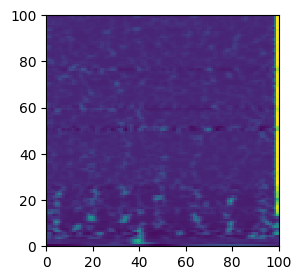

In [51]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(3,3))
ax.pcolormesh(train_data.numpy().squeeze())

# ax[1].pcolormesh(test_data.numpy().squeeze())

## Test wavelet transform

Recovered from: https://ataspinar.com/2018/12/21/a-guide-for-using-the-wavelet-transform-in-machine-learning/ 

In [53]:
data.numpy().squeeze()

array([-0.00182927, -0.05020337, -0.04130486, ..., -0.01886664,
        0.00407801,  0.00020733])

#### Plot wavelet

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


200 46.72038800000001
2400


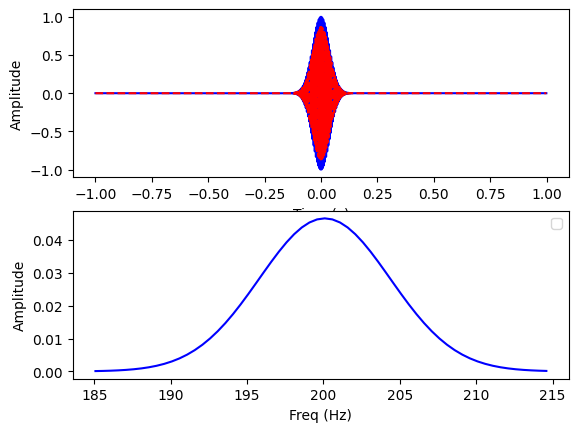

In [154]:
from scipy.fft import fft
# setup parameters
srate = 1200         # in hz
time  = np.arange(-1,1, 1/srate) # best practice is to have time=0 at the center of the wavelet
frex_range  = np.arange(0,590,10)        # frequency of wavelet, in Hz
nCycles_range = np.logspace(np.log10(5), np.log10(150), len(frex_range)) 

i = 20
frex = frex_range[i]
nCycles = 0.0000363292 * frex**2 + 0.215155*frex + 2.23622 
print(frex, nCycles)


# create sine wave (actually cosine, just to make it nice and symmetric)
sine_wave = np.exp( 1j*2*np.pi*frex*time )

# create Gaussian window
# define s
# s = 0.12732395447351627 # 8 cycles in 10 Hz
# print('nCycles', s*(2*np.pi*frex))
s = nCycles/(2*np.pi*frex)
gaus_win = np.exp(-time**2/(2*s**2));

# now create Morlet wavelet
cmw = np.multiply(sine_wave, gaus_win)

fig, ax = plt.subplots(nrows=2, ncols=1)

ax[0].plot(time, np.real(cmw), 'b', label='real part')
ax[0].plot(time, np.imag(cmw), '--r', label='img part')
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('Amplitude')

# Freq domain
pnts = len(time);

mwX = np.abs(fft( cmw )/pnts);
hz  = np.linspace(0,srate,pnts);
print(len(hz))

ax[1].plot(hz[max(2*frex-30, 0):2*frex+30], mwX[max(2*frex-30, 0):2*frex+30], 'b')
# ax[1].plot(hz[150:180], mwX[150:180], 'b')
# ax[1].plot(hz, mwX, 'b')
ax[1].set_xlabel('Freq (Hz)')
ax[1].set_ylabel('Amplitude')
plt.legend()
plt.show()

In [56]:
import scipy.fft as scifft
import scipy.stats as stats

# variable number of wavelet cycles
# setup parameters
srate = 1200         # in hz
time  = np.arange(-1,1+1/srate, 1/srate) # best practice is to have time=0 at the center of the wavelet
frex  = np.arange(1,590,5)        # frequency of wavelet, in Hz
nCycles = np.logspace(np.log10(5), np.log10(200), len(frex)) #150
# nCycles = np.ones(len(frex_range))*4

half_wave = int((len(time)-1)/2);

# FFT parameters
data_sig = data.numpy().squeeze()

nKern = len(time);

nData = len(data_sig);

nConv = nKern+nData-1;

dataX = scifft.fft(data_sig, nConv)

# initialize output time-frequency data

tf = np.zeros((len(frex),nData));

for fi in range(len(frex)):
    
    # create wavelet and get its FFT
    nCycles[fi] = 0.0000363292 * frex[fi]**2 + 0.215155*frex[fi] + 2.23622 
    s = nCycles[fi]/(2*np.pi*frex[fi])
    cmw = np.multiply(np.exp(2*1j*np.pi*frex[fi]*time), np.exp(-time**2/(2*s**2)))
    
    cmwX = scifft.fft(cmw, nConv);

    # max-value normalize the spectrum of the wavelet
    cmwX = cmwX/np.max(cmwX);
    
    # run convolution
    conv = scifft.ifft(np.multiply(cmwX,dataX),nConv);
    conv = conv[half_wave:-half_wave];
    
    # put power data into big matrix
    tf[fi,:] = np.abs(conv)**2;

# db normalization (we'll talk about this in the next lecture)
baseline = np.mean(tf, axis=1)
tfDB = stats.zscore(tf,axis=1)#(np.divide(tf, baseline.reshape(-1,1)))

(118, 3600)


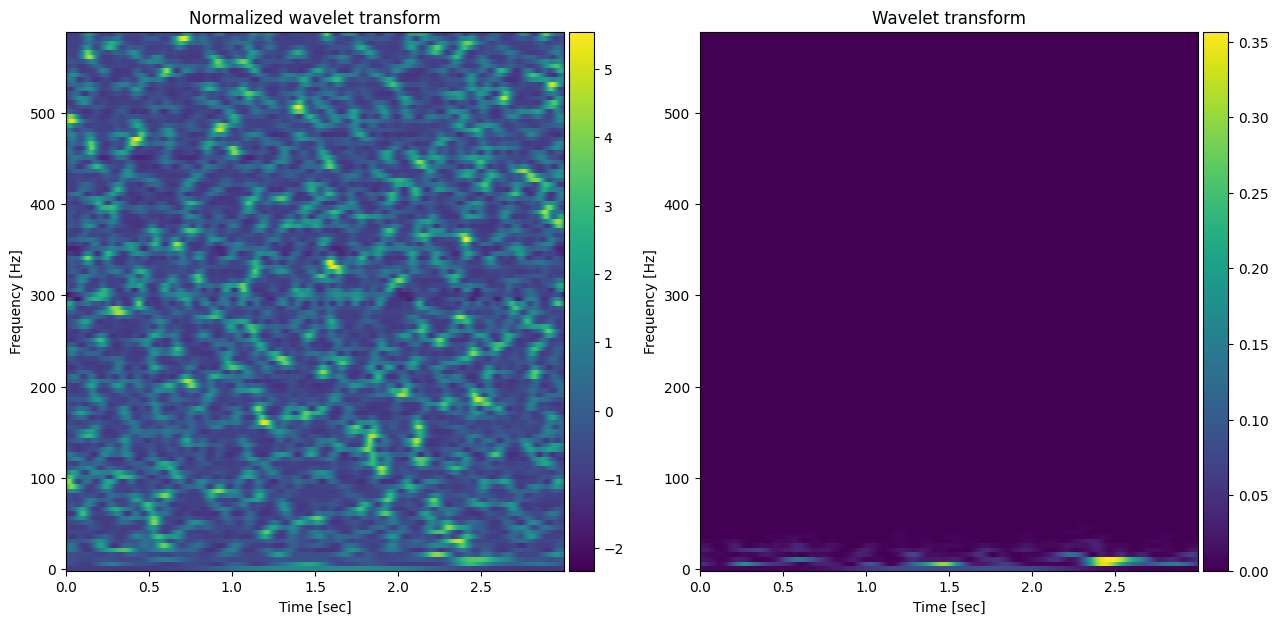

In [57]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
print(tfDB.shape)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,7))
im1 = ax[0].pcolormesh(np.arange(nData)/srate, frex, tfDB)
ax[0].set_ylabel('Frequency [Hz]')
ax[0].set_xlabel('Time [sec]')
ax[0].set_title('Normalized wavelet transform')
divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')

im2 = ax[1].pcolormesh(np.arange(nData)/srate, frex, tf)
ax[1].set_ylabel('Frequency [Hz]')
ax[1].set_xlabel('Time [sec]')
ax[1].set_title('Wavelet transform')
divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
col = fig.colorbar(im2, cax=cax, orientation='vertical')
plt.show()

In [77]:
# Test resize
tf = transforms.Resize((100, 100))
spectro = np.expand_dims(tfDB, axis=0)
spectro = torch.from_numpy(spectro)

In [78]:
spectro_resized = tf(spectro)
spectro_resized.shape

torch.Size([1, 100, 100])

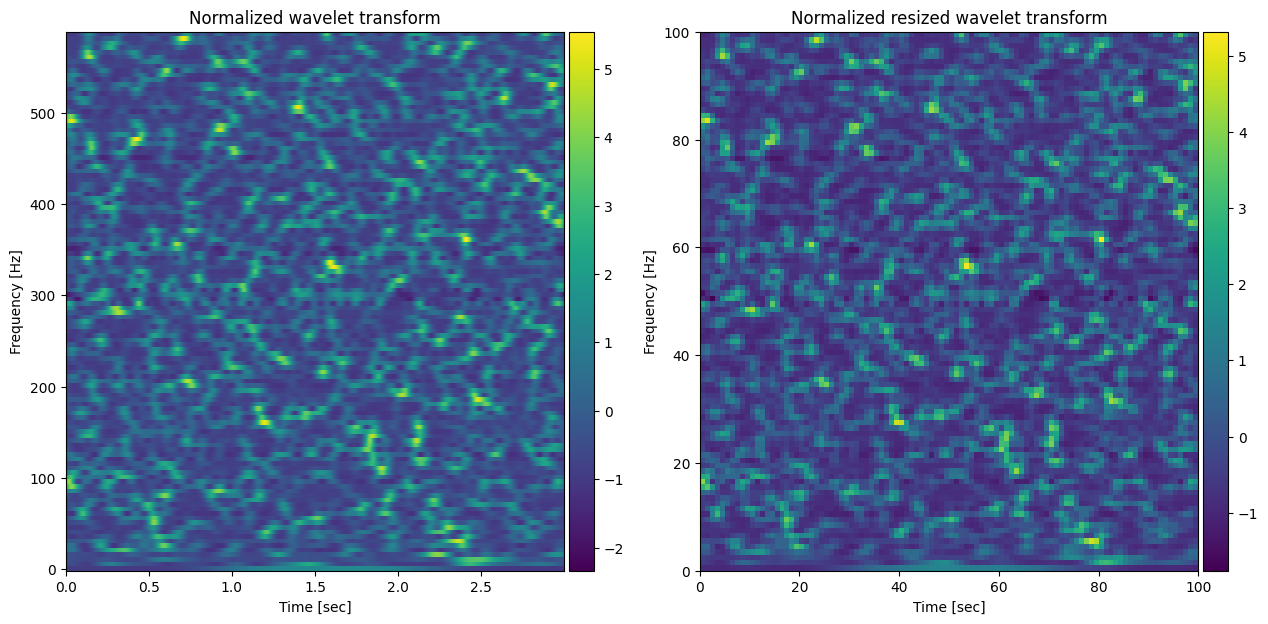

In [79]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,7))
im1 = ax[0].pcolormesh(np.arange(nData)/srate, frex, tfDB)
ax[0].set_ylabel('Frequency [Hz]')
ax[0].set_xlabel('Time [sec]')
ax[0].set_title('Normalized wavelet transform')
divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')

im2 = ax[1].pcolormesh(spectro_resized.numpy().squeeze())
ax[1].set_ylabel('Frequency [Hz]')
ax[1].set_xlabel('Time [sec]')
ax[1].set_title('Normalized resized wavelet transform')
divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical')

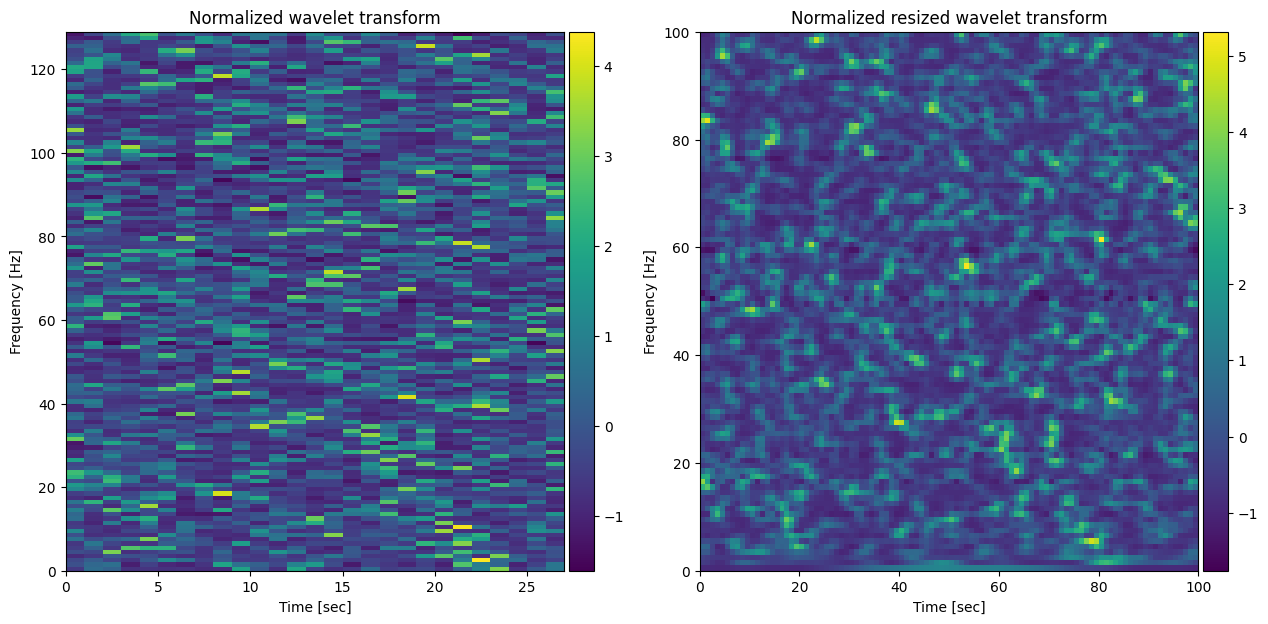

In [81]:
from scipy import stats
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,7))
im1 = ax[0].pcolormesh(stats.zscore(data_spec.squeeze(), axis=1))
ax[0].set_ylabel('Frequency [Hz]')
ax[0].set_xlabel('Time [sec]')
ax[0].set_title('Normalized wavelet transform')
divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')

im2 = ax[1].pcolormesh(spectro_resized.numpy().squeeze())
ax[1].set_ylabel('Frequency [Hz]')
ax[1].set_xlabel('Time [sec]')
ax[1].set_title('Normalized resized wavelet transform')
divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical')

## Test preprocessing

In [63]:
import mne

In [64]:
# Get example data
inputZip = '/home/mcesped/scratch/Datasets/Dataset_Fnusa.zip'
with zipfile.ZipFile(inputZip, mode="r") as archive:
    with archive.open('DATASET_FNUSA/y010055.mat') as myfile:
        data = scipy.io.loadmat(myfile)['data'].squeeze()

In [65]:
data.shape

(15000,)

In [66]:
np.unique(df_total.electrode_type)

array(['depth', 'strip'], dtype=object)

In [67]:
# Get data from df
df_chn = df_total.loc[df_total['segment_id']=='y010050']
df_chn

,anatomy,category_id,channel,electrode_type,institution,patient_id,reviewer_id,segment_id,soz,category_name
index,,,,,,,,,,
10050,gyrus temporalis medius,3,A'9,depth,fnusa,2,3,y010050,0,physiology


In [68]:
df_total.iloc[10002]

anatomy           gyrus temporalis medius
category_id                             3
channel                               A'8
electrode_type                      depth
institution                         fnusa
patient_id                              2
reviewer_id                             3
segment_id                        y010002
soz                                     0
category_name                  physiology
Name: 10002, dtype: object

In [78]:
df_total.iloc[10000]['electrode_type']

'depth'

In [69]:
chn_name = df_chn['channel'].tolist()
# To get channel type, map to mne names
types_map = {
    'depth': 'seeg',
    'strip': 'ecog'
}
type_chn = [types_map[df_chn['electrode_type'].tolist()[0]]]
srate = len(data)/3
# Create info
info = mne.create_info(chn_name, ch_types=type_chn, sfreq=srate)
print(info)

<Info | 7 non-empty values
 bads: []
 ch_names: A'9
 chs: 1 sEEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 2500.0 Hz
 meas_date: unspecified
 nchan: 1
 projs: []
 sfreq: 5000.0 Hz
>


Creating RawArray with float64 data, n_channels=1, n_times=15000
    Range : 0 ... 14999 =      0.000 ...     3.000 secs
Ready.
Using matplotlib as 2D backend.


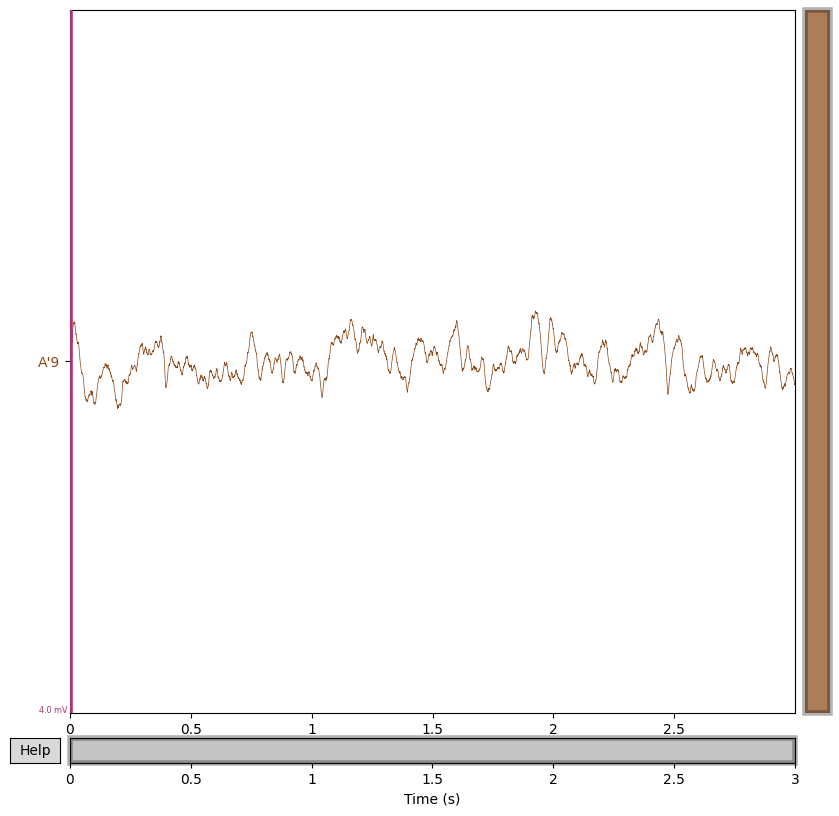

In [70]:
# Create raw
raw = mne.io.RawArray(data.reshape(1,-1)/10000, info)
_ = raw.plot(scalings={'seeg':2000e-6})

Setting up high-pass filter at 0.1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Filter length: 165001 samples (33.000 s)



/tmp/ipykernel_15966/3747174769.py:2: RuntimeWarning: filter_length (165001) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  filter_params = mne.filter.create_filter(


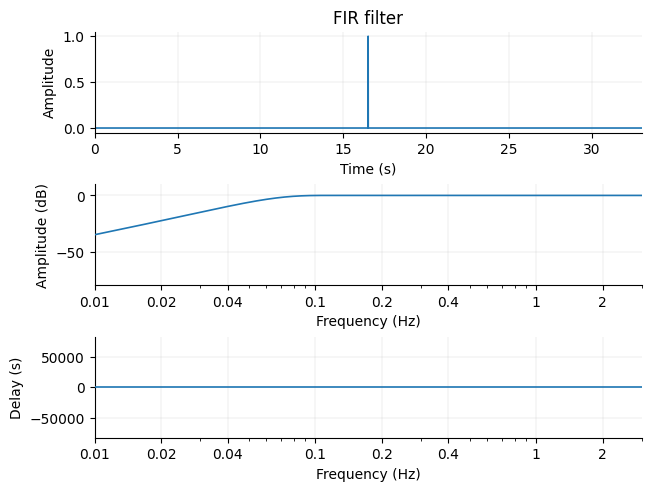

In [79]:
# High pass filter
filter_params = mne.filter.create_filter(
    raw.get_data(), raw.info["sfreq"], l_freq=0.1, h_freq=None
)
_ = mne.viz.plot_filter(filter_params, raw.info["sfreq"], flim=(0.01, 3))

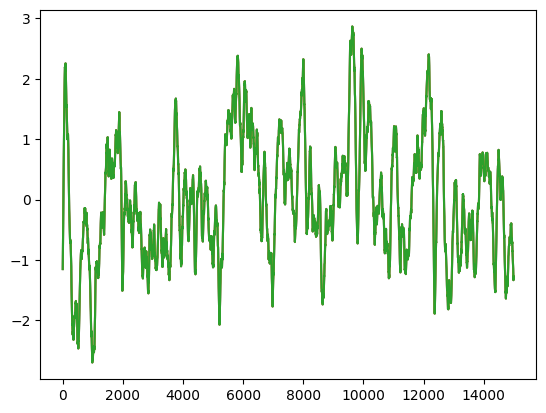

In [82]:
%matplotlib inline
plt.plot(data)
plt.show()

In [99]:
raw_highpass = raw.copy().filter(l_freq=0.1, h_freq=None)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Filter length: 165001 samples (33.000 s)



/tmp/ipykernel_15966/3447631311.py:1: RuntimeWarning: filter_length (165001) is longer than the signal (15000), distortion is likely. Reduce filter length or filter a longer signal.
  raw_highpass = raw.copy().filter(l_freq=0.1, h_freq=None)


In [93]:
raw.get_data().shape

(1, 15000)

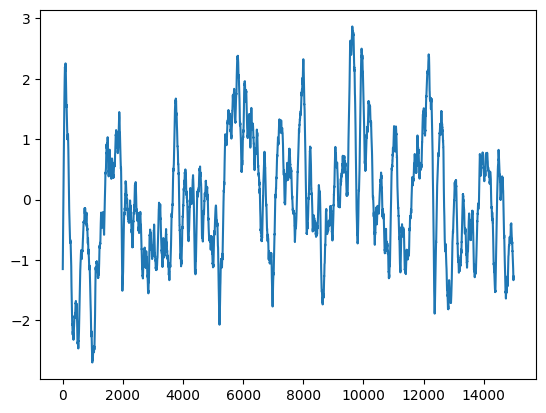

In [97]:
plt.plot(raw.get_data().squeeze()*10000)
plt.show()

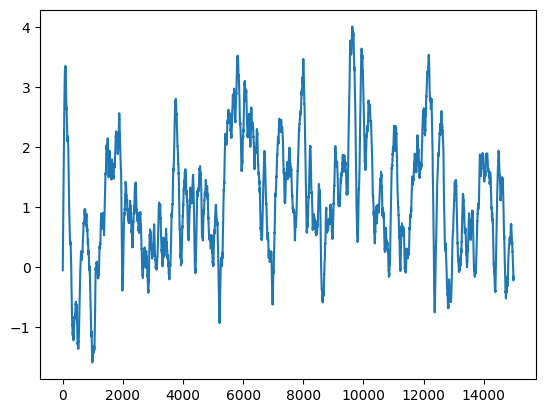

In [100]:
plt.plot(raw_highpass.get_data().squeeze()*10000)
plt.show()